In [22]:
%matplotlib inline

In [23]:
from classes.DQNagentClass import Agent
from envs.createEnvs import createNNEnv

import matplotlib.pyplot as plt
import numpy as np
import torch

In [24]:
env = createNNEnv()

Loading models...
Models loaded


c:\Users\el_sa\anaconda3\envs\TFG\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment gridNN-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [25]:
def trainDQN(agent, path_to_save, n_episodes = 100, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.996):
    """Deep Q-Learning
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
    """
    scores = [] # list containing score from each episode
    durations = [] # list containing duration of each episode
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state,_ = env.reset()
        score = 0
        for t in range(1, max_t+1):
            action = agent.act(state,eps)
            #print("State: ", state,"Action: ",action)
            next_state,reward,done,_,_ = env.step(action)
            agent.step(state,action,reward,next_state,done)
            ## above step decides whether we will train(learn) the network actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will train the network or otherwise we will add experience tuple in our replay buffer.
            state = next_state
            score += reward

            if done or t == max_t:
                print('Episode: {}\tSteps: {}'.format(i_episode,t))
                scores.append(score)
                durations.append(t)
                break

            eps = max(eps*eps_decay,eps_end)## decrease the epsilon

    # save the model weights
    torch.save(agent.qnetwork_local.state_dict(), path_to_save)

    return scores, durations

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#print(env.action_space.n, env.observation_space.shape[0])

#Si cambio los seed de los agentes superan muchas veces el max_t de 200
dqnagent1 = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)
dqnagent2 = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)
dqnagent3 = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)
dqnagent4 = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)
dqnagent5 = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)

agents_arr = [dqnagent1, dqnagent2, dqnagent3, dqnagent4, dqnagent5]
scores_arr = []
durations_arr = []

In [39]:
#TRAINING
train = False
if train:
    for agent in agents_arr:
        print("Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
        path_to_save = "../data/models/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        scores, durations = trainDQN(agent, path_to_save)
        scores_arr.append(scores)
        durations_arr.append(durations)
else:
    for agent in agents_arr:
        path_to_load = "../data/models/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        agent.qnetwork_local.load_state_dict(torch.load(path_to_load))
        agent.qnetwork_local.eval()

Agent 1 steps stats: 	Average 39.75 	Std dev 104.64 	Median 8.0
Agent 2 steps stats: 	Average 45.83 	Std dev 133.29 	Median 8.0
Agent 3 steps stats: 	Average 45.91 	Std dev 129.3 	Median 8.0
Agent 4 steps stats: 	Average 41.59 	Std dev 66.88 	Median 8.0
Agent 5 steps stats: 	Average 27.59 	Std dev 40.31 	Median 8.0


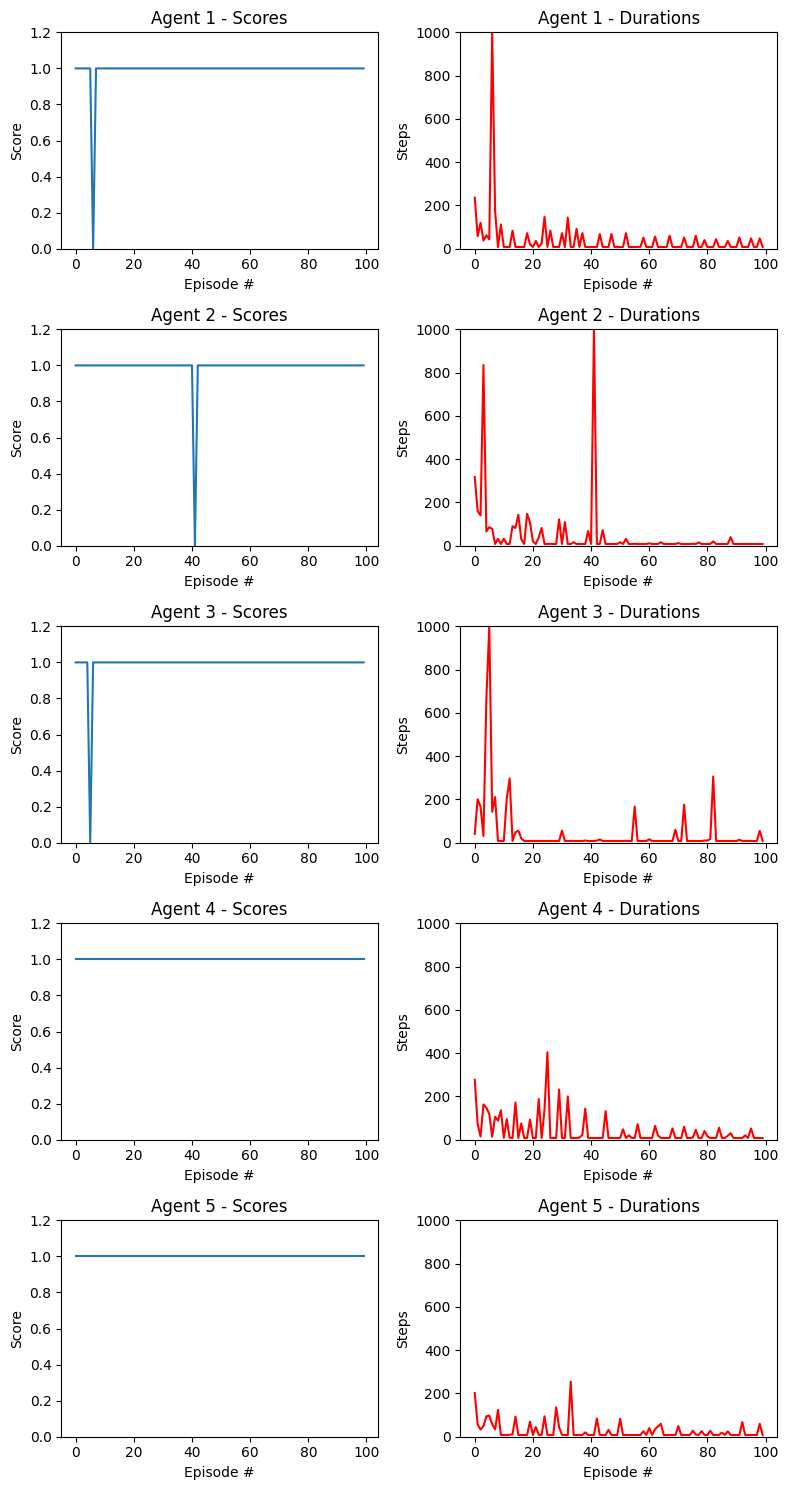

In [40]:
# Create a figure with subplots for each pair
fig, axes = plt.subplots(len(agents_arr), 2, figsize=(8, 3*len(agents_arr)))

for i in range(len(agents_arr)):
    scores = scores_arr[i]  # Access the scores for the current agent
    durations = durations_arr[i]  # Access the durations for the current agent

    # Print information before each pair of subplots
    print("Agent", i+1, "steps stats:", "\tAverage", np.mean(durations), "\tStd dev", round(np.std(durations), 2), "\tMedian", np.median(durations))

    # Define the axes for the current agent's pair of subplots
    ax_scores = axes[i, 0]
    ax_durations = axes[i, 1]

    # Plot the scores in the first subplot
    ax_scores.plot(np.arange(len(scores)), scores)
    ax_scores.set_ylabel('Score')
    ax_scores.set_xlabel('Episode #')
    ax_scores.set_title(f'Agent {i+1} - Scores')
    
    # Set Y-axis limits for scores between 0 and 1
    ax_scores.set_ylim(0, 1.2)

    # Plot the durations in the second subplot
    ax_durations.plot(np.arange(len(durations)), durations, 'r')
    ax_durations.set_ylabel('Steps')
    ax_durations.set_xlabel('Episode #')
    ax_durations.set_title(f'Agent {i+1} - Durations')

    # Set Y-axis limits for durations between 0 and 1000
    ax_durations.set_ylim(0, 1000)

# Adjust layout for better readability
plt.tight_layout()

# Show the combined plot
plt.show()

In [41]:
def create_grids(agent, env):
    from collections import defaultdict

    n_rows, n_cols = env.unwrapped.num_rows, env.unwrapped.num_cols

    state_value = defaultdict(float)
    policy = defaultdict(int)
    agent.qnetwork_local.eval()

    for col in range(n_cols):
        for row in range(n_rows):
            state = torch.from_numpy(np.array([row,col])).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = agent.qnetwork_local(state)
            obs = (row, col)
            state_value[obs] = float(np.max(action_values.cpu().data.numpy()[0]))
            policy[obs] = int(np.argmax(action_values.cpu().data.numpy()[0]))

            #print(" State: ",state.cpu().data.numpy()[0],"Action values: ",action_values.cpu().data.numpy()[0])
            #print(" State value: ",state_value[state],"Policy: ",policy[state])

    # create a grid for the state values
    value_grid = np.zeros((n_rows, n_cols))
    for obs, value in state_value.items():
        value_grid[obs] = value

    # create a grid for the policy. In each state we should show the action that has the highest int(np.argmax(action_values))
    policy_grid = np.zeros((n_rows, n_cols))
    for obs, action in policy.items():
        policy_grid[obs] = action

    string_policy_grid = np.chararray((n_rows, n_cols), unicode=True)
    for i in range(5):
        for j in range(5):
            #Grid positions [0,2], [1,2], [3,2], [4,2] are walls, so we dont want to show an action for them, instead show an X. 
            #We also dont want to show an action for the goal, so we show a G in the grid position [0,4]
            if j == 2 and (i == 0 or i == 1 or i == 3 or i == 4):
                string_policy_grid[i][j] = 'X'
            elif i == 0 and j == 4:
                string_policy_grid[i][j] = 'G'
            elif policy_grid[i][j] == 0:
                string_policy_grid[i][j] = '↑'
            elif policy_grid[i][j] == 1:
                string_policy_grid[i][j] = '↓'
            elif policy_grid[i][j] == 2:
                string_policy_grid[i][j] = '←'
            elif policy_grid[i][j] == 3:
                string_policy_grid[i][j] = '→'
            else:
                string_policy_grid[i][j] = 'X'
    #print(string_policy_grid)

    return value_grid, policy_grid, string_policy_grid

In [30]:
def plot_string_policy(string_policy_grid):
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch

    map_data = np.array(string_policy_grid)
    
    colors = ['red', 'black', 'lightgreen', 'green', 'gray']
    cmap = ListedColormap(colors)

    # Create an array of integers based on the character array
    numeric_map = np.zeros(map_data.shape, dtype=int)
    for i, char in enumerate(['↓', 'X', '→', 'G', '↑']):
        numeric_map[map_data == char] = i

    # Create the plot using imshow
    fig, ax = plt.subplots()
    im = ax.imshow(numeric_map, cmap=cmap, norm=plt.Normalize(0, len(colors)))

    # Add character annotations
    for i in range(map_data.shape[0]):
        for j in range(map_data.shape[1]):
            char = map_data[i, j]
            ax.text(j, i, char, ha='center', va='center', color='black', fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="gray", edgecolor="black", label="Up"),
        Patch(facecolor="red", edgecolor="black", label="Down"),
        Patch(facecolor="blue", edgecolor="black", label="Left"),
        Patch(facecolor="lightgreen", edgecolor="black", label="Right"),
        Patch(facecolor="green", edgecolor="black", label="Goal"),
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    return fig

In [36]:
value_grids = []
policy_grids = []
string_policy_grids = []

for agent in agents_arr:
    value_grid, policy_grid, string_policy_grid = create_grids(agent, env)
    value_grids.append(value_grid)
    policy_grids.append(policy_grid)
    string_policy_grids.append(string_policy_grid)

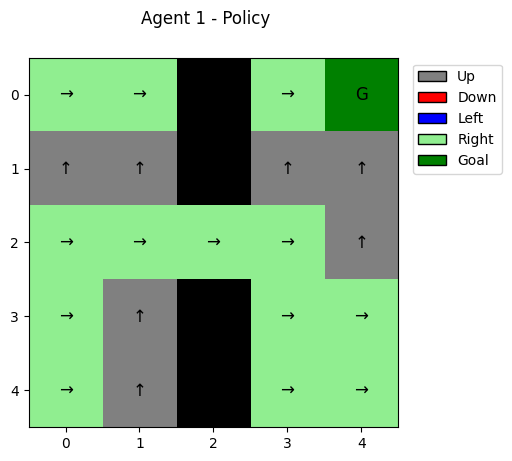

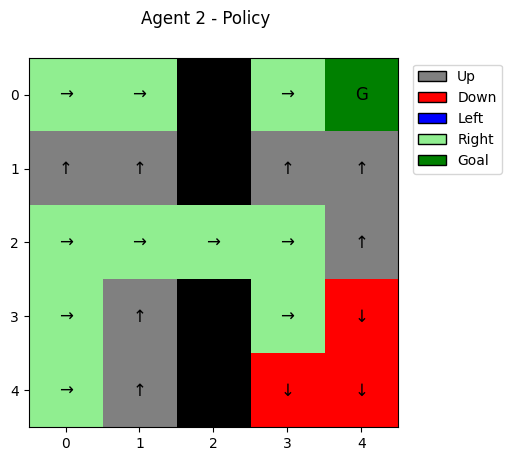

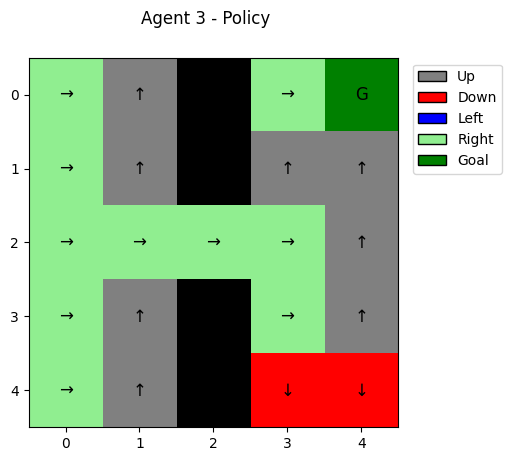

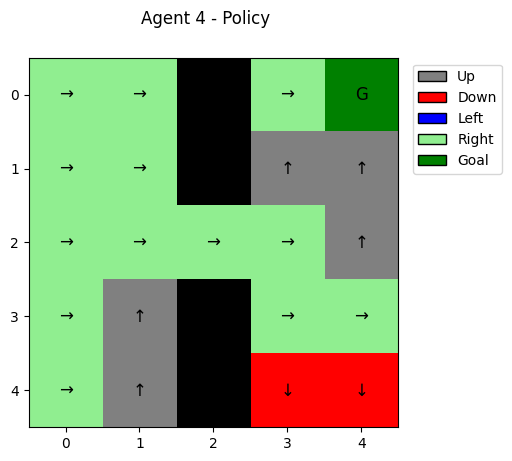

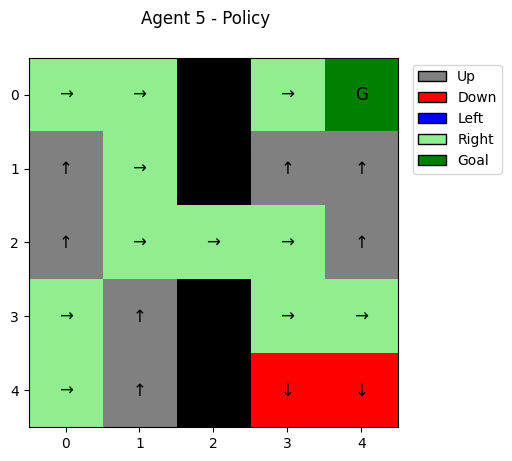

In [42]:
for i in range(len(agents_arr)):
    #print("Agent", i+1, "value grid:")
    #print(value_grids[i])
    #print("Agent", i+1, "policy grid:")
    #print(policy_grids[i])
    #print("Agent", i+1, "policy grid string:")
    #print(string_policy_grids[i])
    fig = plot_string_policy(string_policy_grids[i])
    fig.suptitle(f'Agent {i+1} - Policy')
plt.show()

In [43]:
#load the weights from file
agent_replay = Agent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0)
agent_replay.qnetwork_local.load_state_dict(torch.load('../data/models/DQNagent1.pt'))
agent_replay.qnetwork_local.eval()

with open(f"../data/csv/historyDQN.csv", 'a') as f:
    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")
    for i in range(1):
        obs, _ = env.reset()

        t = 0
        done = False
        while not done:
            action = agent_replay.act(obs)
            prev_state = [obs[0], obs[1], action]
            obs, rew, done, _, _ = env.step(action)

            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")
            t += 1
        print("Agente", i+1, "terminado en", t, "pasos")


Agente 1 terminado en 8 pasos
